In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict


In [3]:

device = torch.device("cpu")
device

device(type='cuda')

In [5]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

In [6]:
from torchinfo import summary
import segmentation_models_pytorch as smp


# In thông tin chi tiết mô hình
summary(
    model,
    input_size=(1, 3, 256, 256),  # Batch size = 1, RGB image, size 256x256
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=3  # Hiển thị sâu đến cấp 3
)


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
UnetPlusPlus                                  [1, 3, 256, 256]          [1, 3, 256, 256]          --                        --                        --
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          [1, 3, 256, 256]          --                        --                        --
│    └─Conv2d: 2-1                            [1, 3, 256, 256]          [1, 64, 128, 128]         9,408                     [7, 7]                    154,140,672
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         [1, 64, 128, 128]         128                       --                        128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         [1, 64, 128, 128]         --                        --                        --
│    └─MaxPool2d: 2-4                         [1, 64, 128, 128]  

In [7]:
num_classes = 3
learning_rate = 1e-04
batch_size = 2
epochs = 10
image = "data/train/train/"
masks =  "data/train_gt/train_gt/"

train_size = 0.9
valid_size = 0.1
torch.manual_seed(1)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [15]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path=None):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [os.path.join(images_path, image_name) for image_name in images_list]
        
        self.images_list = images_list
        self.masks_path = masks_path
        self.masks_list = None
        
        if masks_path:
            masks_list = os.listdir(masks_path)
            masks_list = [os.path.join(masks_path, mask_name) for mask_name in masks_list]
            self.masks_list = masks_list
        
        self.transform = Compose([Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])

        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        
        # Open image
        data = Image.open(img_path).convert("RGB")
        data = self.transform(data) / 255
        
        if self.masks_list:  # If masks are available
            mask_path = self.masks_list[index]
            label = Image.open(mask_path).convert("L")
            label = self.transform(label) / 255
            label = torch.where(label > 0.65, 1.0, 0.0)
            label = torch.argmax(label, 0).type(torch.int64)
            
            return data, label
        
        return data, img_path  # For test set, return data and path
    
    def __len__(self):
        return len(self.images_list)

In [16]:
test = 'data/test/test'
unet_dataset = UNetDataClass(image, masks)
unet_test = UNetDataClass(test, None)
test_dataloader = DataLoader(unet_test, batch_size=batch_size, shuffle=True)

In [10]:
train_set, valid_set = random_split(unet_dataset, 
                                    [int(train_size * len(unet_dataset)) , 
                                     int(valid_size * len(unet_dataset))])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [11]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  
            optimizer.zero_grad() 
            outputs = model(images) 
            loss = criterion(outputs, labels)  
            loss.backward() 
            optimizer.step()  
            running_loss += loss.item()



        train_loss = running_loss / len(train_loader)
        


        # Validation 
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()



        val_loss = val_running_loss / len(val_loader)
     
 

        print(f"Epoch [{epoch + 1}/{epochs}]")
        print(f"    Train Loss: {train_loss:.4f}")
        print(f"    Val Loss: {val_loss:.4f}")

    return 

In [12]:
train_and_validate(model,train_dataloader,valid_dataloader, optimizer,criterion)

Epoch [1/5]
    Train Loss: 0.4220
    Val Loss: 0.1277
Epoch [2/5]
    Train Loss: 0.0961
    Val Loss: 0.0904
Epoch [3/5]
    Train Loss: 0.0656
    Val Loss: 0.0653
Epoch [4/5]
    Train Loss: 0.0493
    Val Loss: 0.0547
Epoch [5/5]
    Train Loss: 0.0373
    Val Loss: 0.0495


In [79]:
def rle_encoding(mask):
    """
    Convert a binary mask into RLE format.
    Args:
        mask (np.ndarray): 2D numpy array of 0s and 1s representing the binary mask.
    Returns:
        str: Run-Length Encoding as a string.
    """
    pixels = mask.flatten(order='F')  # Flatten in column-major order
    pixels = np.concatenate([[0], pixels, [0]])  # Add boundary pixels
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(map(str, runs))

def evaluate(model, test_loader, output_csv="submission.csv"):
    """
    Evaluate the model on test_loader and create a submission file with RLE encoding.
    
    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        output_csv: Path to save the submission CSV.
    """
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    submission_data = []

    with torch.no_grad():
        for images, image_paths in test_loader:
            images = images.to(device)  # Đưa ảnh về thiết bị
            outputs = model(images)  # Dự đoán

            # Duyệt qua từng ảnh trong batch
            for i, image_path in enumerate(image_paths):
                predictions = torch.argmax(outputs[i], dim=0)  # Dự đoán cho ảnh i
                predicted_image = predictions.cpu().numpy()  # Chuyển dự đoán thành NumPy array

                # Mã hóa RLE cho mỗi lớp (0, 1, 2)
                rle_mask = rle_encoding(predicted_image)

                # Lấy tên file không có phần mở rộng
                file_name = os.path.splitext(os.path.basename(image_path))[0]

                # Thêm kết quả vào danh sách
                submission_data.append({
                    "Id": file_name,
                    "Expected": rle_mask  # Lưu kết quả mã hóa RLE
                })

    # Tạo DataFrame từ danh sách kết quả
    submission_df = pd.DataFrame(submission_data)

    # Lưu thành file CSV
    submission_df.to_csv(output_csv, index=False)
    print(f"Submission file saved as {output_csv}")

In [80]:
evaluate(model, test_dataloader)

ValueError: operands could not be broadcast together with shapes (28,) (29,) (28,) 

Batch index: 2
Number of pixels with value 1: 0
Number of pixels with value 2: 64151
Distribution of pixel values:
Value: 0, Count: 1385
Value: 2, Count: 64151


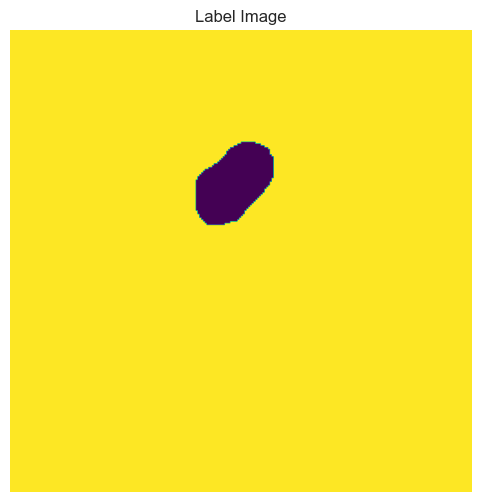

In [66]:
# Lấy một batch từ train_dataloader
for i, (batch_images, batch_labels) in enumerate(train_dataloader):
    # Kiểm tra nếu batch có ít nhất một nhãn bằng 0
    if (batch_labels == 1).any():
        print(f"Batch index: {i}")
        break

# Đưa ảnh về thiết bị (CPU/GPU)
images = batch_images.to(device)
labels = batch_labels.to(device)  # Nếu cần nhãn

# Chạy ảnh qua mô hình
model.eval()  # Chuyển sang chế độ đánh giá
with torch.no_grad():  # Không cần tính toán gradient
    outputs = model(images)  # Dự đoán

# Lấy nhãn của ảnh đầu tiên trong batch
label_image = labels[1]  # Nhãn của ảnh thứ hai trong batch (H, W)

# Đếm số lượng pixel với giá trị 1 và 2
num_ones = torch.sum(label_image == 1).item()
num_twos = torch.sum(label_image == 2).item()
print(f"Number of pixels with value 1: {num_ones}")
print(f"Number of pixels with value 2: {num_twos}")

# Kiểm tra phân phối các giá trị trong nhãn
values, counts = torch.unique(label_image, return_counts=True)
print("Distribution of pixel values:")
for value, count in zip(values, counts):
    print(f"Value: {value.item()}, Count: {count.item()}")

# Chuyển nhãn sang NumPy để hiển thị bằng matplotlib
label_image_np = label_image.cpu().numpy()

# Hiển thị nhãn
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(label_image_np, cmap="viridis")  # Sử dụng cmap phù hợp
plt.title("Label Image")
plt.axis("off")
plt.show()


('data/test/test\\aafac813fe3ccba3e032dd2948a80c64.jpeg', 'data/test/test\\8395e56a6d9ba9d45c3dbc695325ded4.jpeg')
Distribution of predicted pixel values:
Value: 0, Count: 583
Value: 1, Count: 44
Value: 2, Count: 64909


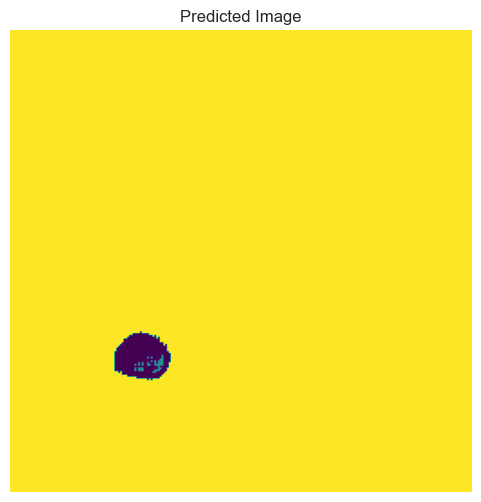

In [69]:
# Chuyển mô hình sang chế độ đánh giá
image, path = next(iter(test_dataloader))
images = image.to(device)
model.eval()
print(path)
with torch.no_grad():
    outputs = model(images)  # Chạy mô hình trên batch
    predictions = torch.argmax(outputs, dim=1)  # Lấy nhãn có xác suất cao nhất

# Chọn nhãn dự đoán của ảnh đầu tiên trong batch
predicted_image = predictions[0]  # (H, W)

# Kiểm tra phân phối các giá trị trong nhãn dự đoán
values, counts = torch.unique(predicted_image, return_counts=True)
print("Distribution of predicted pixel values:")
for value, count in zip(values, counts):
    print(f"Value: {value.item()}, Count: {count.item()}")

# Hiển thị dự đoán
predicted_image_np = predicted_image.cpu().numpy()  # Chuyển sang NumPy để hiển thị

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(predicted_image_np, cmap="viridis")  # Dùng cmap để phân biệt các lớp
plt.title("Predicted Image")
plt.axis("off")
plt.show()


In [70]:
import os

path = 'data/test/test\\aafac813fe3ccba3e032dd2948a80c64.jpeg'

# Lấy tên file không bao gồm phần mở rộng
file_name = os.path.splitext(os.path.basename(path))[0]

print(file_name)  # Kết quả: aafac813fe3ccba3e032dd2948a80c64


aafac813fe3ccba3e032dd2948a80c64
